In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

In [60]:
df_train = pd.read_csv("D:/train.csv", encoding = "ISO-8859-1")
df_test = pd.read_csv("D:/test.csv", encoding = "ISO-8859-1")

In [3]:
df_desc = pd.read_csv('D:/product_descriptions.csv')

In [4]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [5]:
df_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [6]:
df_all = pd.concat((df_train, df_test), axis = 0, ignore_index = True)

In [7]:
df_all.head()

,id,product_title,product_uid,relevance,search_term
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet


In [8]:
df_all.shape

(240760, 5)

In [9]:
df_all = pd.merge(df_all, df_desc, how = 'left', on = 'product_uid')

In [10]:
df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ..."
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ..."
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...


In [11]:
df_all.shape

(240760, 6)

In [12]:
stemmer = SnowballStemmer('english')

In [13]:
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [14]:
def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())

In [15]:
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

In [16]:
import Levenshtein
Levenshtein.ratio('hello', 'hello world')

0.625

In [17]:
df_all['dist_in_title'] = df_all.apply(lambda x: Levenshtein.ratio(x['search_term'], x['product_title']), axis = 1)

In [18]:
df_all['dist_in_desc'] = df_all.apply(lambda x:Levenshtein.ratio(x['search_term'],x['product_description']), axis=1)

In [19]:
df_all['all_texts'] = df_all['product_title'] +  '.' + df_all['product_description'] + '.'

In [20]:
df_all['all_texts'][:5]

0    simpson strong-ti 12-gaug angl.not onli do ang...
1    simpson strong-ti 12-gaug angl.not onli do ang...
2    behr premium textur deckov 1-gal. #sc-141 tugb...
3    delta vero 1-handl shower onli faucet trim kit...
4    delta vero 1-handl shower onli faucet trim kit...
Name: all_texts, dtype: object

In [21]:
from gensim.utils import tokenize
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(list(tokenize(x, errors = 'ignore')) for x in df_all['all_texts'].values)
print(dictionary)

D:\Program Files (x86)\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Dictionary(221877 unique tokens: ['a', 'against', 'alonehelp', 'also', 'and']...)


In [22]:
class MyCorpus(object):
    def __iter__(self):
        for x in df_all['all_texts'].values:
            yield dictionary.doc2bow(list(tokenize(x, errors = 'ignore')))
            
corpus = MyCorpus()

In [24]:
from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(corpus)

In [25]:
tfidf[dictionary.doc2bow(list(tokenize('hello world, good morning', errors = 'ignore')))]

[(1001, 0.2947139124944075),
 (3433, 0.28760732706613895),
 (33767, 0.6587176730120703),
 (35250, 0.6296957697663794)]

In [26]:
from gensim.similarities import MatrixSimilarity

def to_tfidf(text):
    res = tfidf[dictionary.doc2bow(list(tokenize(text, errors = 'ignore')))]
    return res

def cos_sim(text1, text2):
    tfidf1 = to_tfidf(text1)
    tfidf2 = to_tfidf(text2)
    index = MatrixSimilarity([tfidf1], num_features = len(dictionary))
    sim = index[tfidf2]
    return float(sim[0])

In [27]:
text1 = 'hello world'
text2 = 'hello from the other side'
cos_sim(text1, text2)

0.8566456437110901

In [28]:
df_all['tfidf_cos_sim_in_title'] = df_all.apply(lambda x: cos_sim(x['search_term'], x['product_title']),axis = 1)

In [29]:
df_all['tfidf_cos_sim_in_title'][:5]

0    0.274539
1    0.000000
2    0.000000
3    0.133577
4    0.397320
Name: tfidf_cos_sim_in_title, dtype: float64

In [30]:
df_all['tfidf_cos_sim_in_desc'] = df_all.apply(lambda x:cos_sim(x['search_term'], x['product_description']), axis = 1)

In [31]:
import nltk
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [32]:
tokenizer.tokenize(df_all['all_texts'].values[0])

['simpson strong-ti 12-gaug angl.not onli do angl make joint stronger, they also provid more consistent, straight corners.',
 'simpson strong-ti offer a wide varieti of angl in various size and thick to handl light-duti job or project where a structur connect is needed.',
 'some can be bent (skewed) to match the project.',
 'for outdoor project or those where moistur is present, use our zmax zinc-coat connectors, which provid extra resist against corros (look for a "z" at the end of the model number).versatil connector for various 90 connect and home repair projectsstrong than angl nail or screw fasten alonehelp ensur joint are consist straight and strongdimensions: 3 in.',
 'x 3 in.',
 'x 1-1/2 in.mad from 12-gaug steelgalvan for extra corros resistanceinstal with 10d common nail or #9 x 1-1/2 in.',
 'strong-driv sd screw.']

In [33]:
sentences = [tokenizer.tokenize(x) for x in df_all['all_texts'].values]

In [34]:
sentences = [y for x in sentences for y in x]

In [35]:
len(sentences)

1743749

In [36]:
from nltk.tokenize import word_tokenize
w2v_corpus = [word_tokenize(x) for x in sentences]

In [37]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(w2v_corpus, size = 128, window = 5, min_count = 5, workers = 4)

In [38]:
model['good']

D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-4.6232805 ,  0.4130009 ,  2.2232463 , -1.5007128 ,  1.141364  ,
       -0.93095535,  1.2757145 , -2.6114938 ,  1.9619037 ,  0.28701475,
       -0.8359996 , -2.3858943 , -1.683075  , -2.333989  , -4.8686404 ,
        3.3666701 , -0.9760965 ,  0.66155684, -1.2365602 , -1.1737748 ,
       -0.5089023 , -0.6376579 , -3.1448739 , -3.6471314 ,  0.57829505,
       -3.164491  , -1.2672952 , -2.6496058 ,  0.8909873 ,  1.6988394 ,
        1.0629811 ,  1.9689878 , -2.5364609 , -2.0839233 ,  0.4797814 ,
       -0.3992988 , -2.4201741 ,  1.1592269 , -1.942395  ,  0.9896586 ,
       -0.63199157, -0.29577774, -1.3076186 ,  2.2375658 , -0.27235618,
        1.9858788 ,  0.14579384,  0.42325523, -0.3321209 , -1.9552788 ,
       -1.5831658 ,  0.3895103 , -0.7468521 ,  0.2951536 , -0.7097344 ,
        0.09281044, -0.85943466, -1.79731   , -2.8629549 , -3.0903263 ,
       -4.505947  , -0.91957223,  0.44903687, -2.8514557 ,  3.0574603 ,
        3.1845865 ,  1.8952731 , -3.1458533 , -1.7325612 ,  1.00

In [39]:
vocab = model.wv.vocab

#得到任意text的vector
def get_vector(text):
    #建立一个全是0的array
    res = np.zeros([128])
    count =0
    for word in word_tokenize(text):
        if word in vocab:
            res += model[word]
            count += 1
    return res / count

In [40]:
print(get_vector('life is like a box of chocolate'))

[-2.02417114  0.78909415  0.7905939   1.43275598  1.18242385  0.46081001
 -1.00228247 -1.35508312 -0.0137583   0.7080657  -0.82478975  0.53986104
  0.07760893  0.73966229 -1.03019405 -0.26553341 -1.38263925  1.10068
  0.47054851  1.08661636 -0.304839    0.51632303 -0.49125347 -0.28282255
 -0.2488037   0.12395383  0.02283789 -0.52069301  0.51380067  0.11543461
  1.20471513  0.07999113 -1.4945974  -1.20869187 -0.52811781  1.36264455
 -0.58600502  0.69562814 -0.7631928   1.87252646 -0.43703182  0.8915631
 -0.42855041  1.48017183  0.73332838 -1.26157868  0.1282402  -1.6564114
  0.33160103 -0.69423505 -0.15661836  0.55369058 -0.83584838 -1.31922859
  0.3161418  -0.57155819 -0.56804503  0.21659141 -1.1156416   0.31643147
  1.0265626  -0.31053379  0.48118129  0.30659334 -1.62251764 -0.0233481
  2.22526993  0.16283464  0.65037475  1.33059953 -0.20718554 -0.57545797
  0.03140792  1.99664246 -0.36820043  0.57783862  0.46991727 -0.97254199
  0.66220423  1.13686709 -0.16694495 -1.56275953 -0.04202

D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [41]:
from scipy import spatial

def w2v_cos_sim(text1, text2):
    try:
        w2v1 = get_vector(text1)
        w2v2 = get_vector(text2)
        sim = 1 - spatial.distance.cosine(w2v1, w2v2)
        return float(sim)
    except:
        return float(0)

In [42]:
w2v_cos_sim('hello world', 'hello from the other side')

D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


0.2418852269866446

In [43]:
df_all['w2v_cos_sim_in_title'] = df_all.apply(lambda x: w2v_cos_sim(x['search_term'], x['product_title']), axis=1)
df_all['w2v_cos_sim_in_desc'] = df_all.apply(lambda x: w2v_cos_sim(x['search_term'], x['product_description']), axis=1)

D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [44]:
df_all.head(5)

,id,product_title,product_uid,relevance,search_term,product_description,dist_in_title,dist_in_desc,all_texts,tfidf_cos_sim_in_title,tfidf_cos_sim_in_desc,w2v_cos_sim_in_title,w2v_cos_sim_in_desc
0,2,simpson strong-ti 12-gaug angl,100001,3.00,angl bracket,"not onli do angl make joint stronger, they als...",0.190476,0.030418,simpson strong-ti 12-gaug angl.not onli do ang...,0.274539,0.182836,0.477918,0.447085
1,3,simpson strong-ti 12-gaug angl,100001,2.50,l bracket,"not onli do angl make joint stronger, they als...",0.153846,0.022901,simpson strong-ti 12-gaug angl.not onli do ang...,0.000000,0.000000,0.333911,0.153080
2,9,behr premium textur deckov 1-gal. #sc-141 tugb...,100002,3.00,deck over,behr premium textur deckov is an innov solid c...,0.175000,0.017875,behr premium textur deckov 1-gal. #sc-141 tugb...,0.000000,0.053455,0.355443,0.448769
3,16,delta vero 1-handl shower onli faucet trim kit...,100005,2.33,rain shower head,updat your bathroom with the delta vero single...,0.326087,0.048632,delta vero 1-handl shower onli faucet trim kit...,0.133577,0.043712,0.558836,0.487172
4,17,delta vero 1-handl shower onli faucet trim kit...,100005,2.67,shower onli faucet,updat your bathroom with the delta vero single...,0.382979,0.054545,delta vero 1-handl shower onli faucet trim kit...,0.397320,0.098485,0.716399,0.475878


In [45]:
df_all = df_all.drop(['search_term','product_title','product_description','all_texts'],axis=1)

In [72]:
df_train = df_all.loc[df_train.index]
df_train = df_train.fillna(df_train.mean())
df_test = df_all.loc[df_test.index]
df_test = df_test.fillna(df_test.mean())

In [73]:
test_ids = df_test['id']
y_train = df_train['relevance'].values

In [74]:
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [76]:
params = [1,3,5,6,7,8,9,10]
test_scores = []
for param in params:
    clf = RandomForestRegressor(n_estimators=30, max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

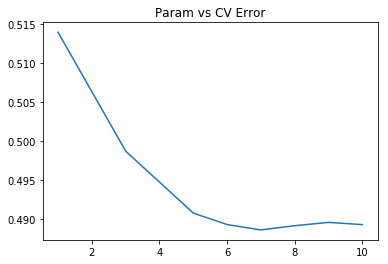

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("Param vs CV Error");

In [78]:
rf = RandomForestRegressor(n_estimators=30, max_depth=6)

In [79]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [80]:

y_pred = rf.predict(X_test)

In [81]:
pd.DataFrame({"id": test_ids, "relevance": y_pred}).to_csv('submission.csv',index=False)